# PSYT Data Task

In this Notebook, I will evauate the performance and predictive power of a model that has been trained and tested on data collected from employees answering questions on their psychological state.

The dataset consists of 1,533 entries and each entry represents -

- Column 1 - Tells us how many short surveys this respondent has filled in.
- Columns 2 and 3  - Give the respondent's age and gender.
- Columns 4 to 8 - Are the mean of one or more responses by this user to several psychological state outcome variables, scaled from 0 to 1 (or missing if never answered).
- Columns 9 and upwards - Are again average responses from 0 to 1, for various trait questions. Missing data are frequent here. These questions combine into 14 different components identified by the two uppercase letters of the column name (that is: AC, BA, BP, CE, EC, EE, GS, KP, RC, SA, SR, SU, TL, TS). For example, avg_CE_3 is a CE question, which stands for Customer Experience.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load the dataset
df = pd.read_csv('Resources/data-scientist-task-data-2017-08-16.csv')

In [3]:
# Look at the first few rows of the dataset
df.head()

,validAlertedResponses,age,gender,avg_happy,avg_energised,avg_focused,avg_stressed,avg_productive1h,avg_AC_10i,avg_AC_2i,...,avg_RC_1,avg_RC_2,avg_RC_3,avg_SA_1,avg_SA_2,avg_SA_3,avg_SA_4,avg_SA_5,avg_SA_6,avg_SA_7
0,64,45-54,male,0.453063,0.486969,0.588578,0.555593,0.615677,0.812500,0.666667,...,0.9375,1.000,NaN,0.583333,0.416667,0.666667,0.250,0.833333,0.5,0.75
1,59,35-44,female,0.635610,0.533881,0.629915,0.118125,0.637674,0.666667,0.625000,...,0.7500,0.875,0.75,0.500000,0.666667,0.666667,0.625,0.500000,0.5,0.75
2,45,45-54,female,0.677800,0.681400,0.659178,0.454545,0.782000,0.875000,1.000000,...,0.5000,1.000,0.50,NaN,NaN,0.750000,0.500,0.750000,0.5,1.00
3,3,35-44,female,0.777667,0.555667,0.722000,NaN,0.750000,NaN,1.000000,...,NaN,NaN,NaN,0.750000,0.750000,NaN,NaN,NaN,NaN,NaN
4,14,16-24,male,0.559643,0.523857,0.797571,0.595143,0.714357,1.000000,1.000000,...,NaN,1.000,NaN,0.750000,0.750000,NaN,NaN,1.000000,NaN,0.50


In [4]:
# Let's look at the data in more detail
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 88 columns):
validAlertedResponses    1533 non-null int64
age                      1532 non-null object
gender                   1532 non-null object
avg_happy                1533 non-null float64
avg_energised            1533 non-null float64
avg_focused              1533 non-null float64
avg_stressed             1323 non-null float64
avg_productive1h         1430 non-null float64
avg_AC_10i               820 non-null float64
avg_AC_2i                846 non-null float64
avg_AC_5i                808 non-null float64
avg_BP_11i               836 non-null float64
avg_BP_13i               808 non-null float64
avg_BP_1i                823 non-null float64
avg_BP_9i                829 non-null float64
avg_EC_2i                810 non-null float64
avg_EC_5i                830 non-null float64
avg_GS_11i               830 non-null float64
avg_KP_10i               827 non-null float64
avg_SR_7m      

From the above I can see that a lot of the psychological state questions have missing (NaN) values. It is unknown if these questions have been answered by employees of not.

As there are 14 different components being used for modelling, I will make the following assumptions - 

- For an entry to be valid an employee will need to have answered at least one question (not a NaN value) in each of the 14 different components.
- Employees who do not answer at least 14 questions will be removed from the dataset.
- Any remaining NaN values will be imputed with the mean value for that question grouped by the employees age group.
- The 14 components will be aggregated by taking the sum of their individual question values.

To do this I will identify the indices of the rows where users have not answered a question in each of the 14 components.

In [5]:
# Create new dataset for searching
missing = df.drop(['validAlertedResponses', 'age', 'gender','avg_happy', 'avg_energised', 
                   'avg_focused', 'avg_stressed', 'avg_productive1h'], axis=1)

In [6]:
# List the 14 components
components = ['avg_AC', 'avg_BA', 'avg_BP', 'avg_CE', 'avg_EC', 'avg_EE', 
             'avg_GS', 'avg_KP', 'avg_RC', 'avg_SA', 'avg_SR', 'avg_SU', 
             'avg_TL', 'avg_TS']

In [7]:
# Define a blank list for storing indices
indices = []
# Loop through 14 components
for i in components:
    #Filter to all the columns associated with the component
    cols = list(missing.filter(like=i))
    total = missing[cols].isnull().sum(axis=1)
    for index, value in enumerate(total):
        if value == len(cols):
            indices.append(index)
# Select only unique indices
indices = np.unique(indices).tolist()

In [8]:
# Drop the identified rows from the dataset
df.drop(df.index[indices], inplace=True)
# There is also an entry with the age and gender missing
# which will be removed to help with data imputation
df = df.dropna(axis=0, how='all', subset=['age'])

In [9]:
# Reset the index
df.reset_index(drop=True, inplace=True)

The dataset now contains entries where users have answered at least one question in each of the 14 different components. This has reduced the number of entries from 1,533 to 823.

Next I will impute the remaining NaN values with the mean value of its component question grouped by age group.

In [10]:
# Create a list of the column names
columns = list(missing.columns)
for i in columns:
    # Calculate the the average responce each age group
    mean_values = df.groupby('age')[i].mean().to_frame().reset_index()
    # Determine indices of the rows with missing age values
    missing_values = df[df[i].isnull()].index.tolist()
    # Loop through the missing age values and set to the median age for it's class
    for x in missing_values:
        nan_index = df.ix[x,'age']
        new_val = mean_values[i][mean_values['age'] == nan_index].tolist()
        df.ix[x,i] = new_val[0]

With all the NaN values removed I will drop the columns not needed for the analysis.

In [11]:
# Create final dataset with onthe the features needed for modelling
data = df.drop(['validAlertedResponses', 'age', 'gender', 'avg_energised', 
                   'avg_focused', 'avg_stressed', 'avg_productive1h'], axis=1)

In [12]:
# Look at the first few rows of the dataset
data.head(3)

,avg_happy,avg_AC_10i,avg_AC_2i,avg_AC_5i,avg_BP_11i,avg_BP_13i,avg_BP_1i,avg_BP_9i,avg_EC_2i,avg_EC_5i,...,avg_RC_1,avg_RC_2,avg_RC_3,avg_SA_1,avg_SA_2,avg_SA_3,avg_SA_4,avg_SA_5,avg_SA_6,avg_SA_7
0,0.453063,0.812500,0.666667,0.750,0.750000,0.500000,0.500000,0.856831,0.875,0.375,...,0.9375,1.000,0.709746,0.583333,0.416667,0.666667,0.250,0.833333,0.5,0.75
1,0.635610,0.666667,0.625000,0.625,0.583333,0.652639,0.750000,0.500000,0.750,0.625,...,0.7500,0.875,0.750000,0.500000,0.666667,0.666667,0.625,0.500000,0.5,0.75
2,0.677800,0.875000,1.000000,0.750,1.000000,0.750000,0.759785,1.000000,1.000,0.750,...,0.5000,1.000,0.500000,0.657178,0.694130,0.750000,0.500,0.750000,0.5,1.00


In [13]:
data.describe()

,avg_happy,avg_AC_10i,avg_AC_2i,avg_AC_5i,avg_BP_11i,avg_BP_13i,avg_BP_1i,avg_BP_9i,avg_EC_2i,avg_EC_5i,...,avg_RC_1,avg_RC_2,avg_RC_3,avg_SA_1,avg_SA_2,avg_SA_3,avg_SA_4,avg_SA_5,avg_SA_6,avg_SA_7
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,...,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000
mean,0.671635,0.787733,0.835850,0.694007,0.745837,0.616929,0.762356,0.856150,0.801809,0.645569,...,0.799703,0.893668,0.712511,0.642566,0.693438,0.718033,0.612612,0.745653,0.599981,0.744438
std,0.147629,0.173447,0.166694,0.196110,0.186749,0.228129,0.172629,0.154769,0.160368,0.225744,...,0.193579,0.142693,0.212300,0.206550,0.204304,0.179447,0.229163,0.193722,0.211014,0.186466
min,0.126108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.578645,0.750000,0.750000,0.625000,0.724047,0.500000,0.738468,0.750000,0.750000,0.500000,...,0.750000,0.833333,0.646429,0.500000,0.625000,0.625000,0.500000,0.666667,0.500000,0.674555
50%,0.680894,0.781529,0.838950,0.750000,0.750000,0.626156,0.750000,0.862319,0.800563,0.650816,...,0.799797,0.937500,0.750000,0.666667,0.714899,0.750000,0.625000,0.750000,0.598684,0.750000
75%,0.765948,0.940972,1.000000,0.750000,0.875000,0.750000,0.875000,1.000000,0.957143,0.750000,...,1.000000,1.000000,0.816964,0.750000,0.750000,0.750000,0.750000,0.875000,0.750000,0.875000
max,0.997587,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the statistics above we can see that there are no missing values and the value ranges are all normal with no outliers present.

Next I will look at the **avg_happy** values in more detail.

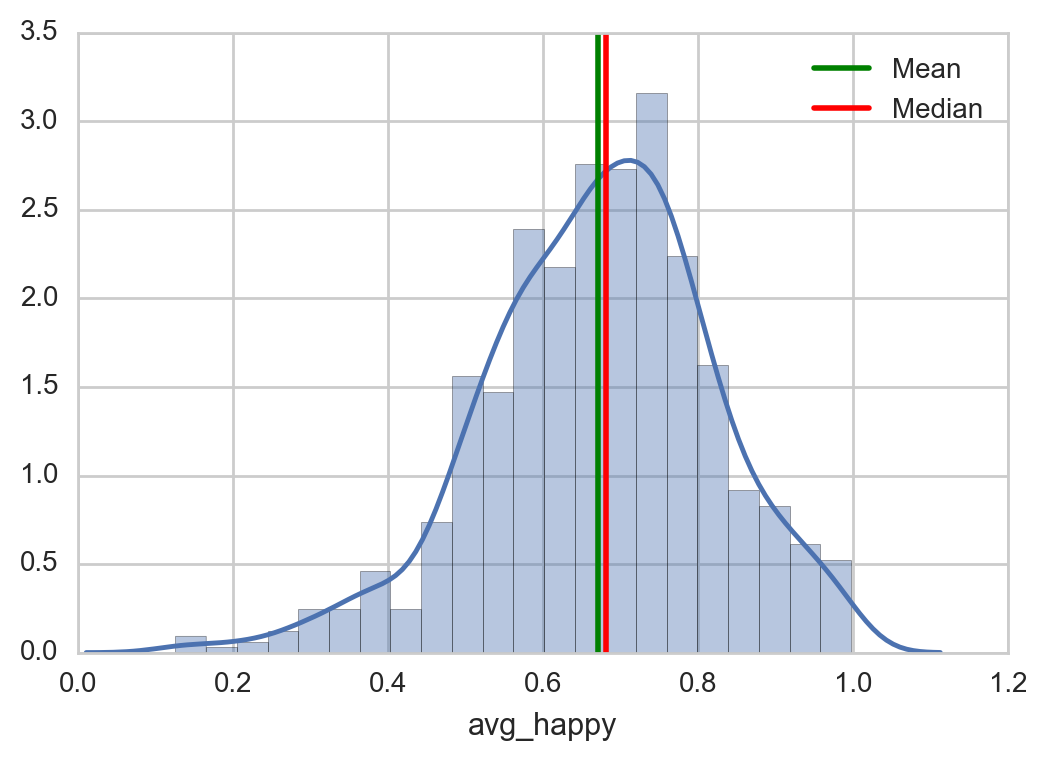

In [14]:
# Plot the distribution of avg_happy
ax = sns.distplot(data.avg_happy)
ax.axvline(data.avg_happy.mean(), color = 'green', linewidth = 2)
ax.axvline(data.avg_happy.median(), color = 'red', linewidth = 2)
ax.legend(['Mean', 'Median'])
plt.show()

This is very close to a normal distribution so I will not need to do anything further. We can see that the mean happiness rating is 0.671.

Before I begin modelling I need to aggregrate the the 80 questions into 14 components.

In [15]:
# List the components
components = ['avg_AC', 'avg_BA', 'avg_BP', 'avg_CE', 'avg_EC', 'avg_EE', 
             'avg_GS', 'avg_KP', 'avg_RC', 'avg_SA', 'avg_SR', 'avg_SU', 
             'avg_TL', 'avg_TS']

In [16]:
# Loop to aggregate the data into only 14 components
for i in components:
    #Filter to all the columns associated with the component and calculate the sum
    cols = data.filter(like=i)
    cols[i] = cols.sum(axis=1)
    data[i] = cols[i]
# Drop the unnecessary columns
data.drop(columns, axis=1, inplace=True)

Next let's see if there are any strong correlations between the components.

In [17]:
# Correlation matrix
corrmat = data.corr()
corrmat

,avg_happy,avg_AC,avg_BA,avg_BP,avg_CE,avg_EC,avg_EE,avg_GS,avg_KP,avg_RC,avg_SA,avg_SR,avg_SU,avg_TL,avg_TS
avg_happy,1.000000,0.487203,0.407081,0.534397,0.338546,0.447250,0.470823,0.428690,0.440055,0.350116,0.460821,0.382115,0.394184,0.422757,0.444232
avg_AC,0.487203,1.000000,0.656386,0.714230,0.428906,0.697621,0.657698,0.757732,0.747704,0.615263,0.541106,0.640631,0.731860,0.739738,0.735783
avg_BA,0.407081,0.656386,1.000000,0.650380,0.533227,0.649773,0.703795,0.703081,0.734238,0.612889,0.674081,0.688240,0.700617,0.643652,0.704403
avg_BP,0.534397,0.714230,0.650380,1.000000,0.481410,0.663246,0.716946,0.709725,0.710918,0.574158,0.611165,0.611143,0.672331,0.669853,0.685882
avg_CE,0.338546,0.428906,0.533227,0.481410,1.000000,0.423511,0.626085,0.390444,0.451281,0.415990,0.758283,0.349518,0.373367,0.417093,0.417278
avg_EC,0.447250,0.697621,0.649773,0.663246,0.423511,1.000000,0.606265,0.684949,0.717435,0.633432,0.537477,0.632491,0.718161,0.642793,0.716151
avg_EE,0.470823,0.657698,0.703795,0.716946,0.626085,0.606265,1.000000,0.624742,0.671725,0.569336,0.764862,0.544932,0.591775,0.606838,0.614779
avg_GS,0.428690,0.757732,0.703081,0.709725,0.390444,0.684949,0.624742,1.000000,0.798628,0.605434,0.491775,0.768000,0.813438,0.743964,0.802087
avg_KP,0.440055,0.747704,0.734238,0.710918,0.451281,0.717435,0.671725,0.798628,1.000000,0.669163,0.563082,0.731518,0.800164,0.730486,0.805564
avg_RC,0.350116,0.615263,0.612889,0.574158,0.415990,0.633432,0.569336,0.605434,0.669163,1.000000,0.546240,0.611390,0.652255,0.575214,0.628211


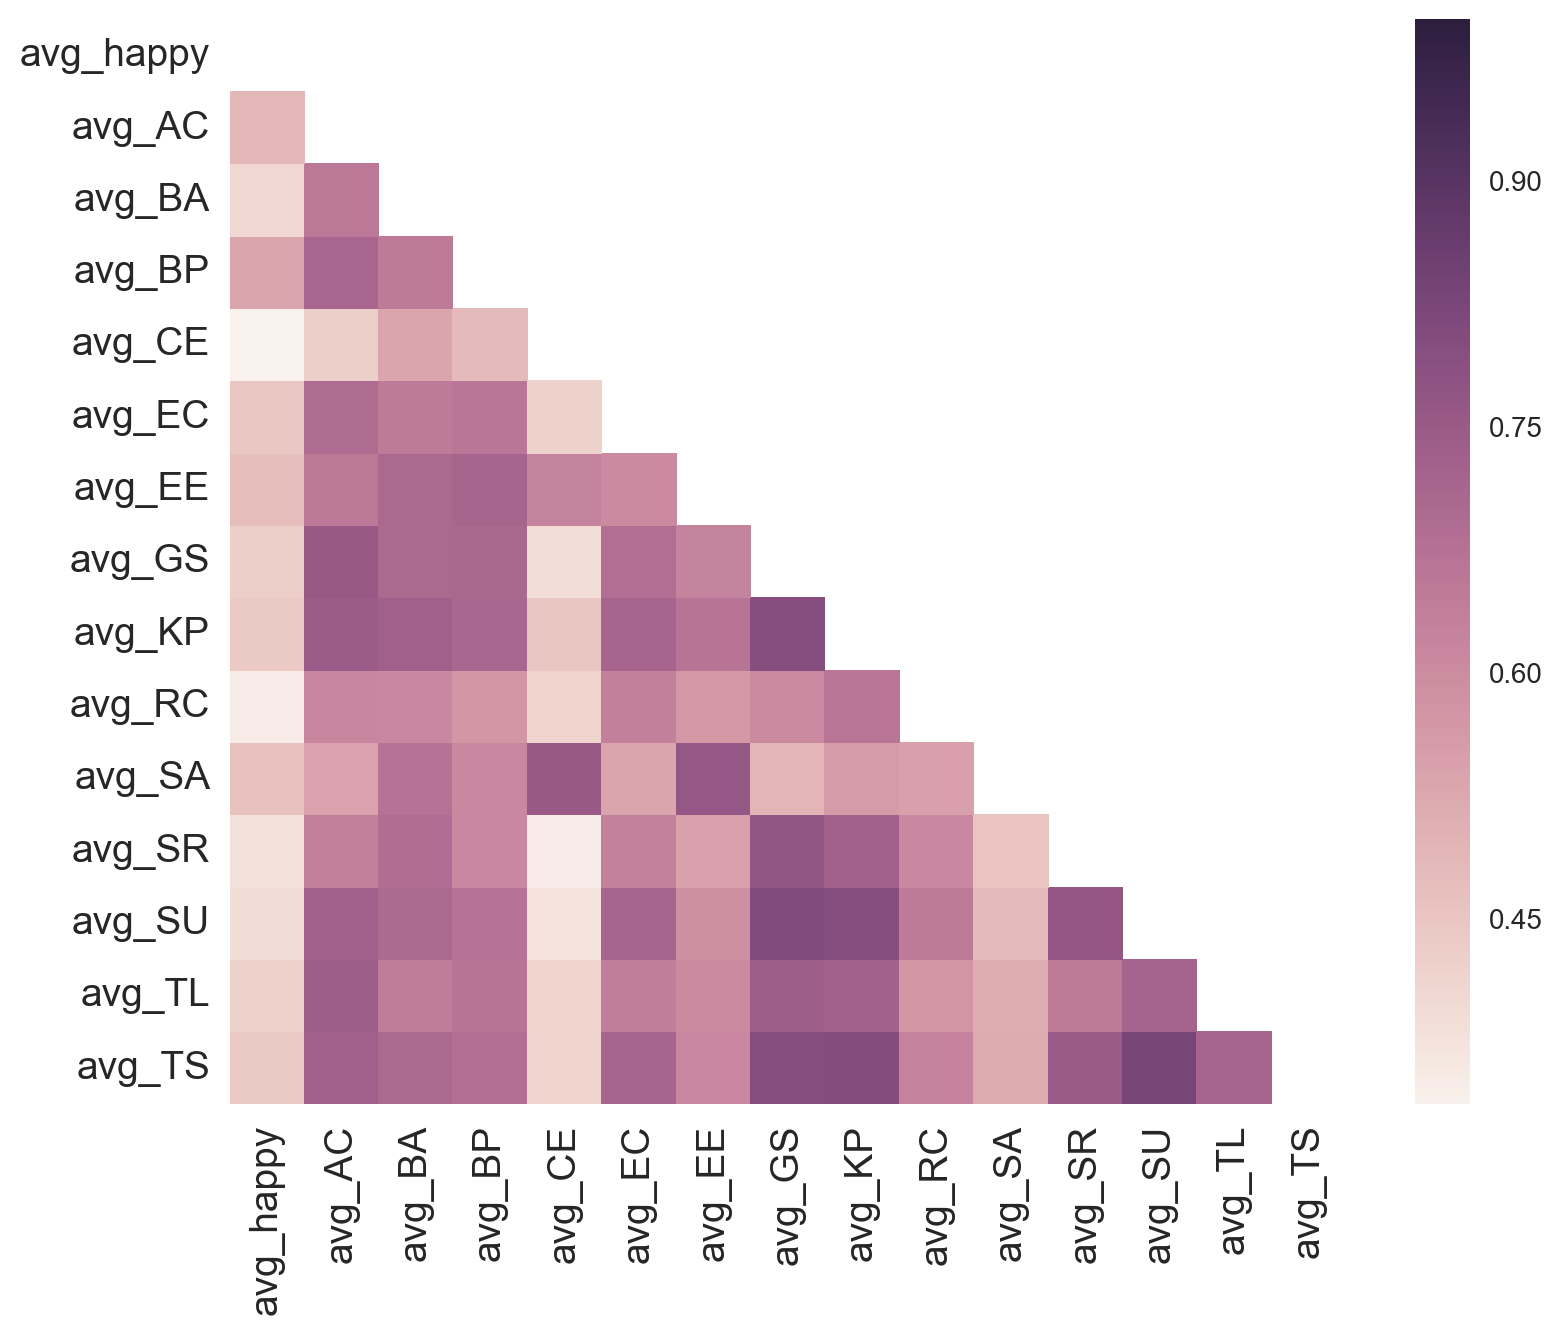

In [18]:
# Let's visualise it in a heatmap
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrmat, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

It is very clear from looking at the heatmap that there is high correlatity between some of the components.

I will look at the most highly correlated components below.

In [19]:
def mosthighlycorrelated(data, num):
    # find the correlations
    corr = data.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    corr *= np.tri(*corr.values.shape, k=-1).T
    # find the top n correlations
    corr = corr.stack()
    corr = corr.reindex(corr.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    corr.columns = ["First_Variable", "Second_Variable", "Correlation"]
    return corr.head(num)

In [20]:
# List the top ten most correlated components
mosthighlycorrelated(data, 10)

,First_Variable,Second_Variable,Correlation
0,avg_SU,avg_TS,0.832801
1,avg_GS,avg_SU,0.813438
2,avg_KP,avg_TS,0.805564
3,avg_GS,avg_TS,0.802087
4,avg_KP,avg_SU,0.800164
5,avg_GS,avg_KP,0.798628
6,avg_GS,avg_SR,0.768000
7,avg_SR,avg_SU,0.764910
8,avg_EE,avg_SA,0.764862
9,avg_CE,avg_SA,0.758283


We can see that **Speak Up**,  **Talk Straight**, **Give Support**, and **Keep Promises** are all very strongly correlated with each other. This is to be expected as looking at the data dictionary shows that the questions cover very similar themes.

Instead of removing components I will apply a Ridge regularisation on the linear regression as it helps with coefficient shrinkage and reducing model complexity.

## Modelling

In [21]:
# Import libraries for modelling
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer

In [22]:
# Create X, y datasets defining the target and variables for modelling
y = data['avg_happy']
X = data[components]

In [23]:
# Standardise the features before splitting into training and test sets
ss = StandardScaler()
Xn = ss.fit_transform(X)

Standardisation is necessary for regularized regression because the beta values for each predictor variable must be on the same scale. If betas are different sizes just because of the scale of predictor variables the regularisation term can't determine which betas are more/less  important based on their size.

In [24]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.3, random_state=13)

In [25]:
# Define the model
ridge_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)

# Fit the model
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([  1.00000e-05,   1.07177e-05, ...,   9.33039e+03,   1.00000e+04]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [26]:
print 'The best alpha value was ', ridge_cv.alpha_

The best alpha value was  96.2227117368


In [27]:
# Calculate the R2 score for the training set
ridge_cv.score(X_train, y_train)

0.3201876852916915

In [28]:
# Calculate the R2 score for the test set
ridge_cv.score(X_test, y_test)

0.34463878037121165

The calculated R2 score for both the train and test sets was 0.328 and 0.341 respectively. This means that 34% of the variance in predicting avg_happy is taken into account.

Because the R2 score is almost the same for the training and test sets we can say that the model generalises very well out of the sample so despite the score being low we can trust the variance we are explaining.

Ridge is able to manage the multicollinearity and get a good result.

In [29]:
# Display the features and coefs into a dataframe sorted by magnitude
top_coefs = pd.DataFrame(dict(feature=X.columns, coef=ridge_cv.coef_, ))
top_coefs.sort_values('coef', inplace=True, ascending=False)
top_coefs

,coef,feature
2,0.035199,avg_BP
0,0.016216,avg_AC
9,0.015881,avg_SA
5,0.008038,avg_EE
7,0.007547,avg_KP
4,0.007493,avg_EC
10,0.007306,avg_SR
12,0.004350,avg_TL
3,0.004030,avg_CE
6,0.003542,avg_GS


<function matplotlib.pyplot.show>

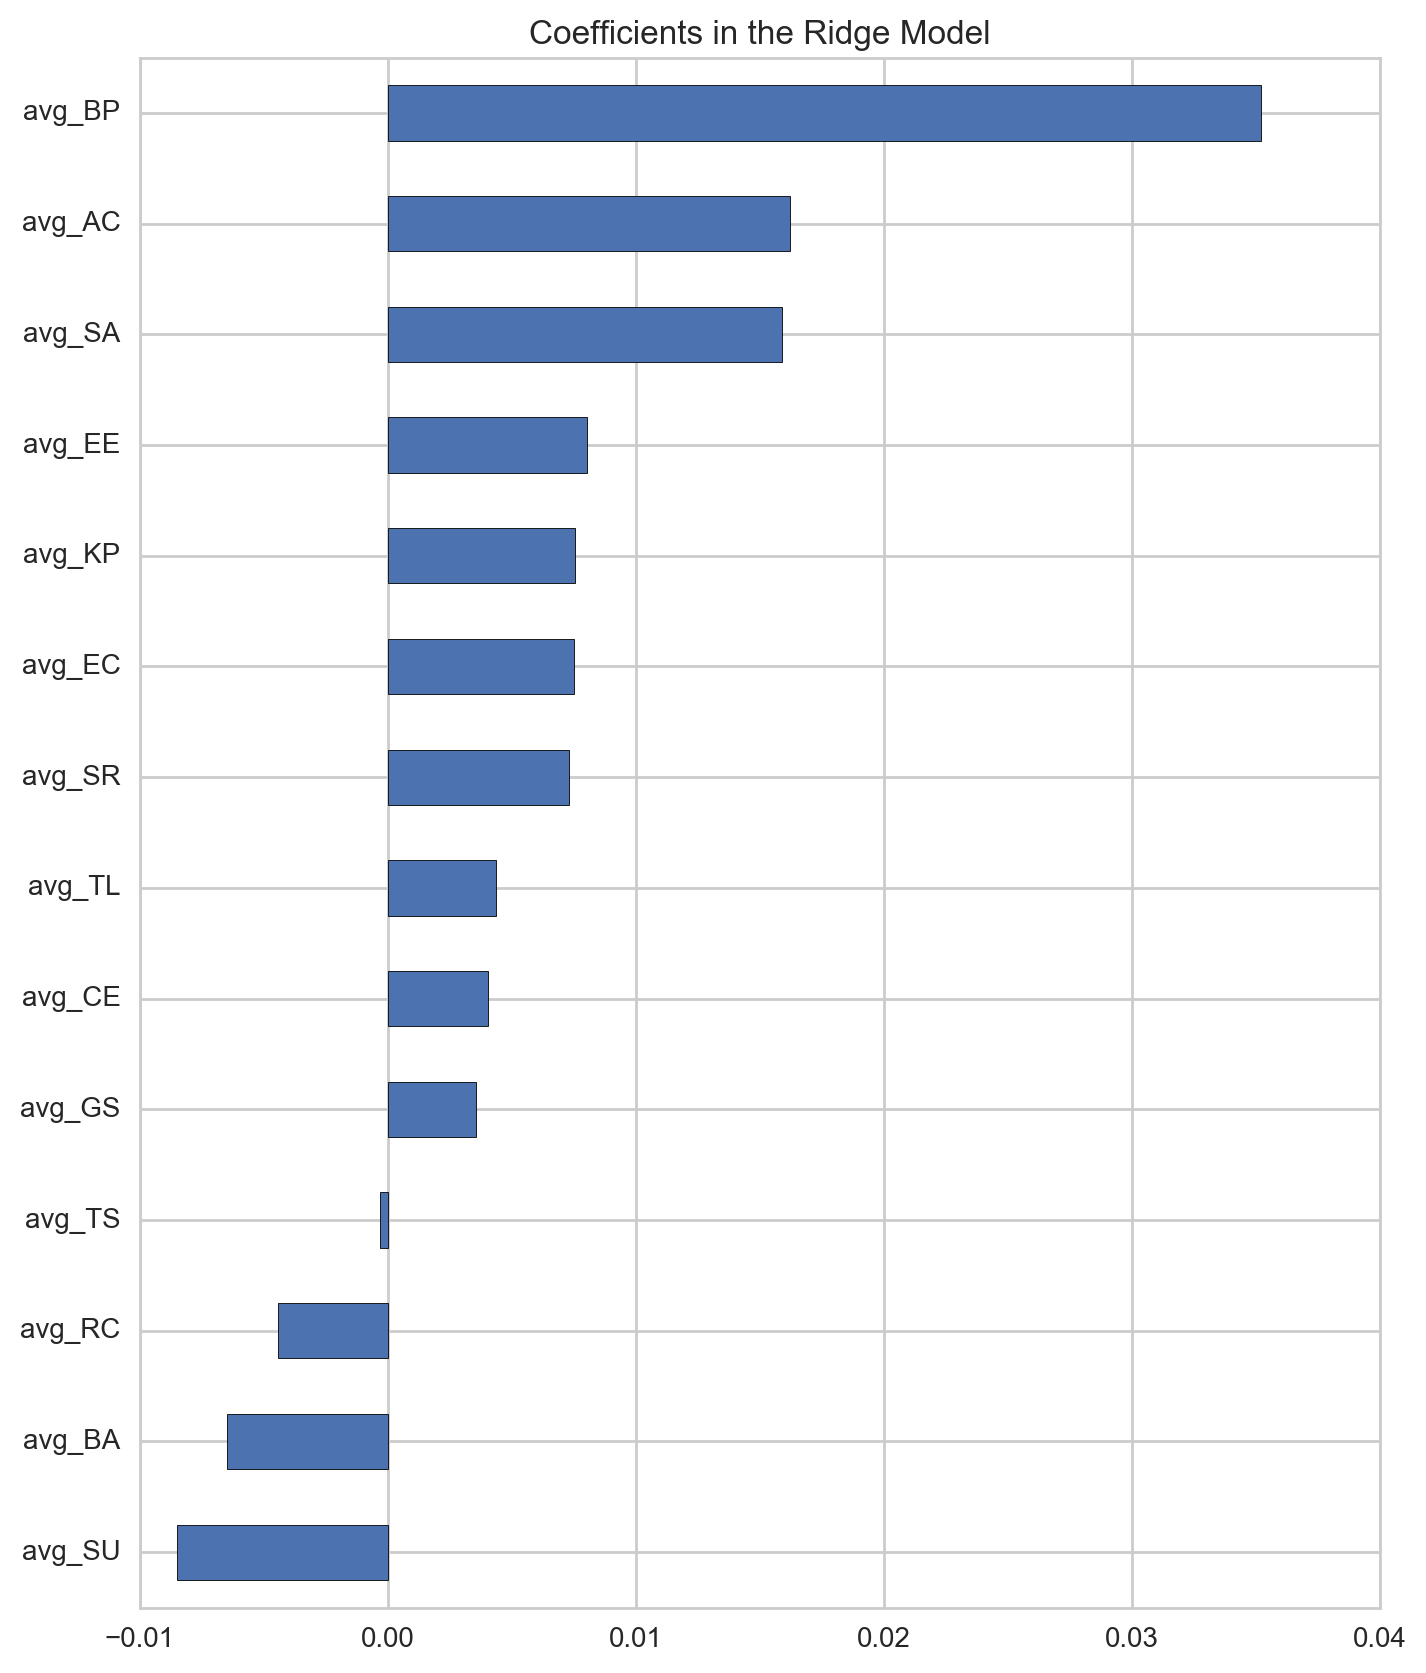

In [30]:
# Define the coeffecients and creata a dataframe
coefs = pd.Series(ridge_cv.coef_, index = X.columns)
top_coefs = pd.concat([coefs.sort_values().head(7),
                     coefs.sort_values().tail(7)])
# Plot the coeffecients
plt.rcParams['figure.figsize'] = (8.0, 10.0)
top_coefs.plot(kind = 'barh', )
plt.title('Coefficients in the Ridge Model')
plt.show

### Summary

---
The aim of the project was to understand the impact that 14 different components has on the average happiness of an employess. The 14 components were aggregated from 80 employee trait questions.

After initial data cleaning and exploration it was found that several of the 14 components were highly correlated. The most highly correlated components were - 

- Speak Up
- Talk Straight
- Give Support
- Keep promoses

Due to collinarity of the components, Ridge regularisation was applied to a linear regression as it helps with coefficient shrinkage and reducing model complexity. 

After running Ridge with the best alpha value the most significant and least significant components were identidied.

**The 3 most significant components:**
- BP
- AC
- SA

**The 3 least significant components:**
- RC
- BA
- SU

<img src="Resources/PSYT.jpg" >



Further investigation is advised to gain a better understand of what is causing the high correlation between the components. 

## Forward Stepwise Regression

In this section I will define a function to run a forward stepwise regression on the dataset. It will work by adding features into the model one at a time until it finds an optimal score for the feature set.

The scoring metric will be adjusted R2 similar to what was used previously.

In [ ]:
# Load library
import statsmodels.formula.api as smf

In [33]:
# Define the function to find the optimal linear model
def forward_selected(data, response):
    
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [34]:
# Run the function on the dataset
step = forward_selected(data, 'avg_happy')

In [39]:
# Print a summary
step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_happy   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     46.61
Date:                Fri, 15 Sep 2017   Prob (F-statistic):           9.87e-68
Time:                        13:00:04   Log-Likelihood:                 578.36
No. Observations:                 823   AIC:                            -1137.
Df Residuals:                     813   BIC:                            -1090.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1522      0.030      5.007      0.000       0.093       0.212
avg_BP         0.0576      0.009      6.204      0.000       0.039       0.076
avg_SA         0.0343      0.007      4.598      0.000       0.020       0.049
avg_AC         0.0306      0.009      3.574      0.000       0.014       0.047
avg_EC         0.0325      0.015      2.129      0.034       0.003       0.063
avg_RC        -0.0220      0.015     -1.445      0.149      -0.052       0.008
avg_BA        -0.0126      0.009     -1.361      0.174      -0.031       0.006
avg_TS         0.0166      0.009      1.941      0.053      -0.000       0.033
avg_SU        -0.0176      0.010     -1.831      0.067      -0.037       0.001
avg_CE        -0.0155      0.014     -1.119      0.263      -0.043       0.012
==============================================================================
Omnibus:                       72.466   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.541
Skew:                          -0.638   Prob(JB):                     6.01e-25
Kurtosis:                       4.274   Cond. No.                         87.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

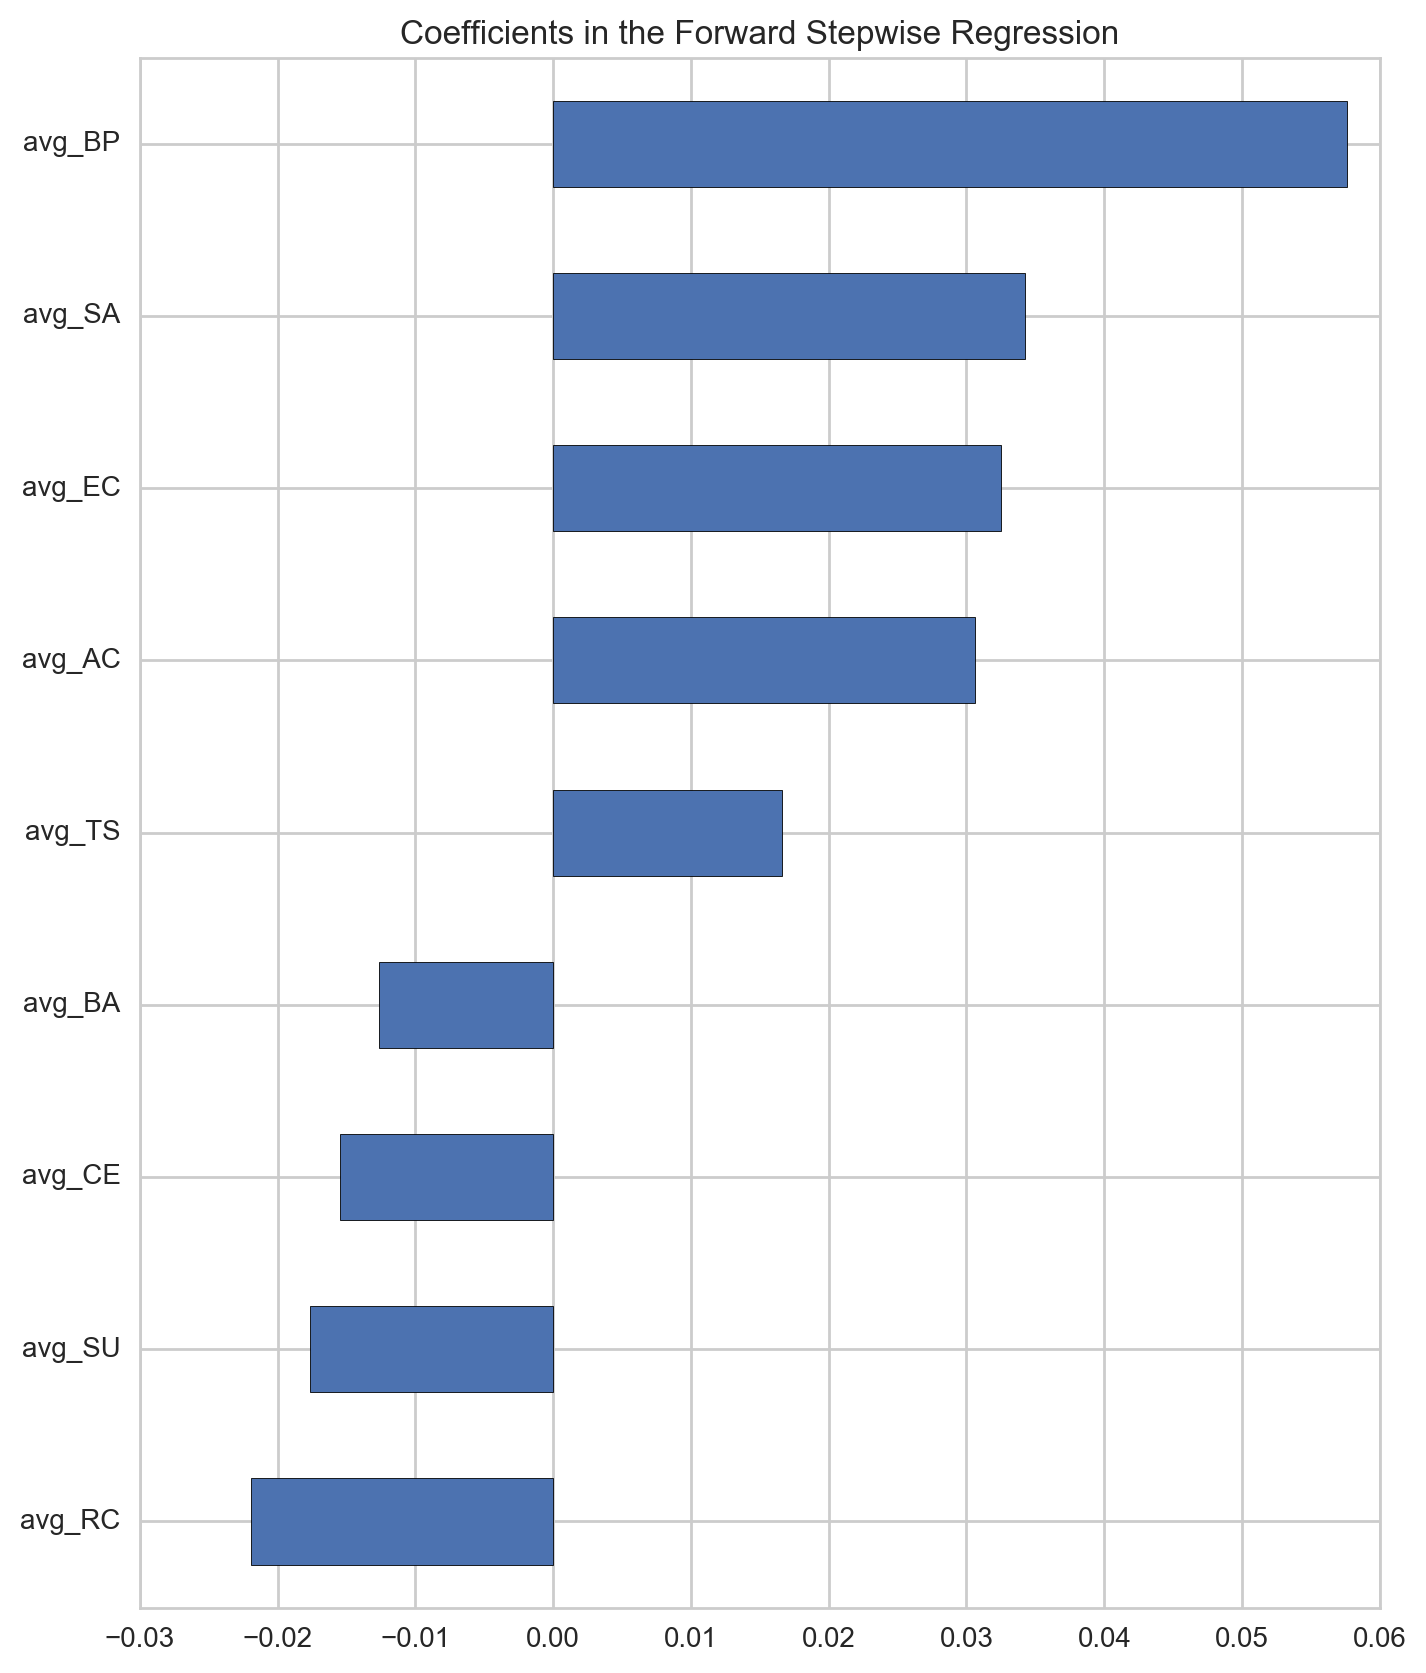

In [55]:
params = step.params[1:]
params.sort_values(inplace=True)
# Plot the coeffecients
plt.rcParams['figure.figsize'] = (8.0, 10.0)
params.plot(kind = 'barh', )
plt.title('Coefficients in the Forward Stepwise Regression')
plt.show()

After running the forward stepwise refression it can be seen from the summary that the optimal model has dropped five of the feature variables. 

The R2 score was found to be ~0.34 which is in line with the Ridge model used previously.

**The 3 most significant components:**
- BP
- SA
- EC

**The 3 least significant components:**
- RC
- SU
- CE

Again, the significance of the component features is in the order similar to the previous Ridge model but with some of the components becoming more/less significant.